# Gesture based control for consumer electronics

Importing required libraries

In [197]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


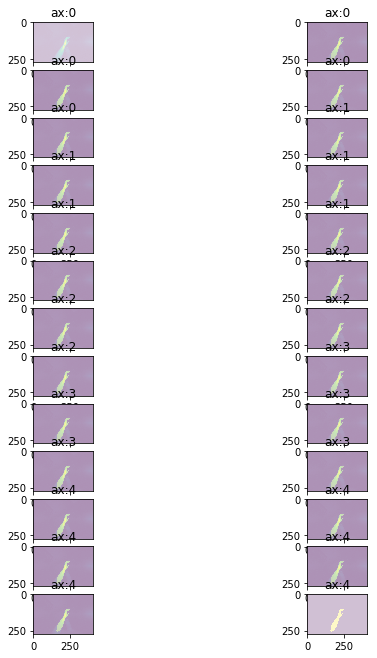

In [213]:
w = 10
h = 10
fig = plt.figure(figsize=(9, 13))
columns = 2
rows = 15

# prep (x,y) for extra plotting
# xs = np.linspace(0, 2*np.pi, 60)  # from 0 to 2pi
# ys = np.abs(np.sin(xs))           # absolute of sine

# ax enables access to manipulate each of subplots
ax = []
for i in range(5):
    for j in range(5):
        img = cv2.imread("work/u"+ str(i+1) + "_" + str(j+1) + ".png")
        img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        k = cv2.normalize(img, dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        blur = cv2.GaussianBlur(k,(5,5),0)
        ret, thresh1 = cv2.threshold(blur, 60, 255, cv2.THRESH_BINARY + 
                                            cv2.THRESH_OTSU)
        nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(thresh1, connectivity=4)
        sizes = stats[:, -1]

        max_label = 1
        max_size = sizes[1]
        for i in range(2, nb_components):
            if sizes[i] > max_size:
                max_label = i
                max_size = sizes[i]

        img2 = np.zeros(output.shape)
        img2[output == max_label] = 255
        
        new_image = img2[stats[max_label][1]:stats[max_label][1]+stats[max_label][3],stats[max_label][0]:stats[max_label][0]+stats[max_label][2]]
        image_for_input = cv2.resize(img2, (100, 100), interpolation = cv2.INTER_NEAREST)
        # create subplot and append to ax
        ax.append( fig.add_subplot(rows, columns, i * 5 + j + 1) )
        ax[-1].set_title("ax:"+str(i))  # set title
        plt.imshow(img, alpha=0.25)
        
        ax.append( fig.add_subplot(rows, columns, i * 5 + j + 2) )
        ax[-1].set_title("ax:"+str(i))  # set title
        plt.imshow(thresh1, alpha=0.25)

# do extra plots on selected axes/subplots
# note: index starts with 0
# ax[2].plot(xs, 3*ys)
# ax[19].plot(ys**2, xs)

plt.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


ValueError: num must be 1 <= num <= 25, not 26

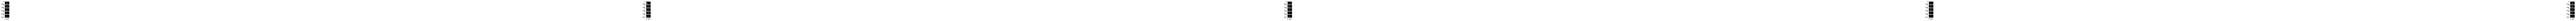

In [208]:
fig=plt.figure(figsize=(375, 2))
ax = []

for i in range(5):
    for j in range(5):
#         print(i,j);
        a = cv2.imread("work/u"+ str(i+1) + "_" + str(j+1) + ".png")
        img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        k = cv2.normalize(img, dst=None, alpha=0, beta=255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        blur = cv2.GaussianBlur(k,(5,5),0)
        ret, thresh1 = cv2.threshold(blur, 60, 255, cv2.THRESH_BINARY + 
                                            cv2.THRESH_OTSU)
        nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(thresh1, connectivity=4)
        sizes = stats[:, -1]

        max_label = 1
        max_size = sizes[1]
        for i in range(2, nb_components):
            if sizes[i] > max_size:
                max_label = i
                max_size = sizes[i]

        img2 = np.zeros(output.shape)
        img2[output == max_label] = 255
        
        new_image = img2[stats[max_label][1]:stats[max_label][1]+stats[max_label][3],stats[max_label][0]:stats[max_label][0]+stats[max_label][2]]
        image_for_input = cv2.resize(img2, (100, 100), interpolation = cv2.INTER_NEAREST)
        ax.append( fig.add_subplot(5, 5, i*5+j+1) )
        plt.imshow(a)
        ax.append( fig.add_subplot(5, 5, i*5+j+2) )
        plt.imshow(thresh1)
        
plt.show()


In [ ]:
img2 = numpy.array(img2)

plt.imshow(new_image) 

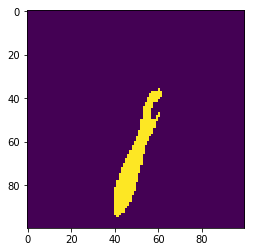

In [153]:
plt.imshow(image_for_input)

In [84]:
from sklearn.neural_network import MLPClassifier

start_time = time.time()
clf = MLPClassifier(hidden_layer_sizes = (100,100), activation = 'relu', solver = 'sgd', max_iter=100, batch_size=100, verbose = 'true', tol=10**-6, learning_rate = 'invscaling', learning_rate_init = 0.2, power_t = 0.5)
clf.fit(input_data_train,output_data_train)
end_time = time.time()
print("Train", clf.score(input_data_train,output_data_train))
print("Test", clf.score(input_data_test,output_data_test))
print("Time", end_time - start_time)

In [145]:
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)

# load pima indians dataset
dataset = numpy.loadtxt("Alphabets/train.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:784]
Y = dataset[:,784]

# create model
model = Sequential()
model.add(Dense(100, input_dim=784, activation='sigmoid'))
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(15, activation='sigmoid'))

# Compile model
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])


# Fit the model
model.fit(X, Y, epochs=100, batch_size=400)

# evaluate the model
scores = model.evaluate(X, Y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

ModuleNotFoundError: No module named 'keras'